# **Task 1: Defining your Problem and Audience**

Users of the King James Bible lack an intelligent, context-aware way to search, explore, and understand biblical content across books, chapters, and themes.

### **Problem Context and Target Audience**

The target user is a Bible Study Leader, Theology Student, or Christian Educator who regularly engages with Scripture for research, teaching, or sermon preparation.

These users often ask nuanced or multi-faceted questions such as:

+ "Where does the Bible talk about forgiveness across the Old and New Testaments?"
+ "Which verses describe God’s mercy using similar language?"
+ "Can you compare how love is portrayed in Psalms vs. in Paul's letters?"

Currently, they rely on keyword-based search or manual reading, which:

+ Fails to capture semantic meaning or cross-book relationships
+ Is time-consuming, especially when preparing thematic studies
+ Lacks a structured, intelligent interface for exploration or summarization

By automating semantic search, cross-referencing, and thematic summarization, we can drastically improve how these users interact with Scripture — making Bible study more efficient, insightful, and personalized.

# **Task 2: Propose a Solution**

### **Proposed Solution & User Experience**

We propose building an **Agentic RAG-powered Bible Explorer**: an interactive semantic search and summarization tool for users to ask complex, open-ended questions about the Bible and receive coherent, faith-aligned, multi-verse responses.

The user interface will feel like a chat with an “AI Bible Scholar.” A Bible Study Leader can ask:

> *“Where does the Bible talk about God’s promises during times of despair?”*

The system will retrieve semantically relevant verses across books, apply agentic reasoning to group and summarize them into themes (e.g., “Hope in Psalms,” “Faith in Hebrews”), and present the output in an interpretable format — optionally citing verse locations and summaries.

Users will save **hours of manual cross-referencing**, gain **deep thematic insight**, and improve the quality of their lessons or sermons.


### **Tools and Architecture Stack**

| Layer                   | Tool                                    | Rationale                                                                              |
| ----------------------- | --------------------------------------- | -------------------------------------------------------------------------------------- |
| **LLM**                 | `gpt-4.1`                               | High performance in language generation, handles abstract religious themes with nuance |
| **Embedding Model**     | `text-embedding-3-small`                | Accurate, fast, OpenAI-supported, and highly cost-effective                            |
| **Orchestration**       | `LangGraph`                             | Ideal for agentic reasoning and stateful multi-step retrieval/summarization            |
| **Vector DB**           | `Qdrant`                                | Fast, production-ready, with robust metadata filtering (e.g., by book, chapter)        |
| **Monitoring**          | `LangSmith`                             | Essential for traceable observability and debugging of RAG flows                       |
| **Evaluation**          | `RAGAS`                                 | Standard for retrieval-based evaluation (faithfulness, precision, relevance, etc.)     |
| **UI**                  | `Chainlit`                              | Streamlined UI for multi-turn semantic chat, markdown-friendly and developer-friendly  |
| **Serving & Inference** | `FastAPI + Docker + Hugging Face Space` | Reliable, scalable, and community-shareable deployment setup                           |


### **Agent Usage and Agentic Reasoning**

We will integrate **two LangGraph-based agents**:

1. **Query Decomposition Agent** – breaks down multi-part queries like:

   > *"What does Jesus say about prayer in the Gospels, and how is it applied in the Epistles?"*

   Into:

   * Sub-query 1: *“What does Jesus say about prayer in the Gospels?”*
   * Sub-query 2: *“How is prayer discussed in the Epistles?”*

2. **Summarization Agent** – interprets retrieved verses, clusters them by semantic meaning or book, and summarizes the findings using chain-of-thought prompting.

Agentic reasoning allows contextual memory, thematic consistency, and accurate mapping of scriptural concepts across Testaments — far beyond traditional keyword search.

# **Task 3: Dealing with the Data**

### **Data Pre-processing**

In [1]:
import pandas as pd
from config import settings

# ─────────────────────────────────────────────────────────────────────────────
# Load and preprocess the King James Version (KJV) Bible TSV file.
# The goal is to extract structured metadata: Book, Chapter, Verse, and Text.
# ─────────────────────────────────────────────────────────────────────────────

# Load KJV Bible data from a .tsv file, skipping the first 2 header rows.
# Assumes the file is located in ./data/ and follows the naming pattern {prefix}.tsv
# Each row has two columns: Reference (e.g., "John 3:16") and Text (verse content).
kjv_df = pd.read_csv(
    f"./data/{settings.DATASET_PREFIX}.tsv",
    sep="\\t",
    skiprows=2,
    names=["Reference", "Text"]
)

# List of book names that contain spaces or numeric prefixes (e.g., '1 Kings', '2 Timothy').
# These are needed to correctly split the "Reference" field into Book, Chapter, and Verse.
special_books = [
    'Song of Solomon', '1 Kings', '2 Kings', '1 Samuel', '2 Samuel',
    '1 Chronicles', '2 Chronicles', '1 Corinthians', '2 Corinthians',
    '1 Thessalonians', '2 Thessalonians', '1 Timothy', '2 Timothy',
    '1 Peter', '2 Peter', '1 John', '2 John', '3 John'
]

def preprocess_reference(ref: str) -> pd.Series:
    """
    Splits a Bible reference string into Book and Chapter:Verse.

    Args:
        ref (str): A string like "John 3:16" or "1 Samuel 17:45"

    Returns:
        pd.Series: [Book, ChapterVerse] where ChapterVerse is still "X:Y"
    """
    for book in special_books:
        if ref.startswith(book):
            # Special handling for books with numbers or spaces
            remaining = ref[len(book):].strip()
            return pd.Series([book, remaining])
    # Default split for simple book names like "John 3:16"
    return pd.Series(ref.split(' ', 1))

# Apply preprocessing to split "Reference" into separate Book and ChapterVerse columns
kjv_df[['Book', 'ChapterVerse']] = kjv_df['Reference'].apply(preprocess_reference)

# Further split ChapterVerse into Chapter and Verse columns
kjv_df[['Chapter', 'Verse']] = kjv_df['ChapterVerse'].str.split(':', n=1, expand=True)

# Convert Chapter and Verse to integers for sorting, indexing, or filtering
kjv_df['Chapter'] = kjv_df['Chapter'].astype(int)
kjv_df['Verse'] = kjv_df['Verse'].astype(int)

# Remove columns that have been decomposed
kjv_df.drop(columns=['ChapterVerse', 'Reference'], inplace=True)

# Save the preprocessed dataframe as a clean CSV
kjv_df.to_csv(f"./data/{settings.DATASET_PREFIX}_preprocessed.csv", index=False)

# Preview 10 random verses for sanity check
kjv_df.sample(10)

/var/folders/g_/16x28wss4bz5_7h7pmt9w29h0000gn/T/ipykernel_9244/1512769297.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  kjv_df = pd.read_csv(f"./data/{settings.DATASET_PREFIX}.tsv", sep="\\t", skiprows=2, names=["Reference", "Text"])


,Text,Book,Chapter,Verse
16535,Let thy fountain be blessed: and rejoice with ...,Proverbs,5,18
12646,"The Levites in the days of Eliashib, Joiada, a...",Nehemiah,12,22
27363,Now there were in the church that was at Antio...,Acts,13,1
6615,"But Barak pursued after the chariots, and afte...",Judges,4,16
7822,"Then said David, Will the men of Keilah delive...",1 Samuel,23,12
1651,And the officers of the children of Israel did...,Exodus,5,19
19376,Thus said the LORD unto me; Go and stand in th...,Jeremiah,17,19
24553,"And straightway all the people, when they behe...",Mark,9,15
15401,[Nor] for the pestilence [that] walketh in dar...,Psalm,91,6
49,And out of the ground the LORD God formed ever...,Genesis,2,19


### **Data Sources and External APIs**

| Source / API                                          | Purpose                                                                                                                                                                                         |
| ----------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **`kjv_preprocessed.csv`**                            | Core knowledge base of biblical content. Each row includes `Text`, `Book`, `Chapter`, and `Verse`, allowing semantic indexing and metadata filtering.                                           |
| **OpenAI APIs (`gpt-4.1`, `text-embedding-3-small`)** | Language generation and semantic embedding for both retrieval and agent reasoning.                                                                                                              |
| **RAGAS**                                             | Evaluation of the RAG pipeline using metrics like **Faithfulness**, **Answer Relevance**, **Context Precision**, and **Context Recall**.                                                        |


### **Default Chunking Strategy**

#### **Strategy**: *Semantic Chunking with Context-Aware Merging*

* **Step 1**: Start with verse-level entries as base units (each row in `kjv_preprocessed.csv`)
* **Step 2**: Group **2–5 adjacent verses** together if:

  * They share the same `Book` and `Chapter`
  * They form a logical thematic unit (measured via cosine similarity threshold ≥ 0.8 between embeddings)
* **Step 3**: Ensure the resulting chunk is ≤ 256 tokens for efficient embedding

#### **Why This Strategy?**

* Verse-level granularity is too small for meaningful semantic search.
* Chapter-level is often too broad or diluted.
* Grouping adjacent verses allows richer semantic context while preserving theological integrity and referential clarity.
* This also improves **context recall** and **faithfulness** in downstream RAG outputs, which is critical in religious settings where misinterpretation must be avoided.


# **Task 4 — Baseline Embeddings and RAGAS evaluation**

In [1]:
import os
import pandas as pd
from pathlib import Path

from config import settings

# Import utilities and modules for chunking, embedding, retrieval, evaluation, and test set generation
from embed.chunking import chunk_verses
from embed.embeddings import get_openai_embedding_model
from embed.qdrant_vectorstore import create_qdrant_vectorstore

from core.ragas_evaluator import evaluate_ragas
from pipeline.rag_chain import build_rag_chain, print_rag_response
from pipeline.golden_testset_generator import generate_golden_testset

# Set up a local cache directory for storing intermediate data (e.g., chunked docs, metrics)
CACHE_DIR = Path(f"cache/{settings.DATASET_PREFIX}")
CACHE_DIR.mkdir(exist_ok=True)

# ─────────────────────────────────────────────────────────────
# Utility functions to persist and load intermediate artifacts
# ─────────────────────────────────────────────────────────────

def save_df(df: pd.DataFrame, name: str):
    """
    Saves a DataFrame to the cache directory as a CSV file.

    Args:
        df (pd.DataFrame): DataFrame to save
        name (str): Base filename (without extension)
    """
    df.to_csv(CACHE_DIR / f"{name}.csv", index=False)

def load_df(name: str):
    """
    Loads a cached CSV file as a DataFrame if it exists.

    Args:
        name (str): Base filename (without extension)

    Returns:
        pd.DataFrame or None: Loaded DataFrame or None if file not found
    """
    path = CACHE_DIR / f"{name}.csv"
    return pd.read_csv(path) if path.exists() else None

# ─────────────────────────────────────────────────────────────
# Main Phase 1: Baseline RAG Pipeline
# ─────────────────────────────────────────────────────────────

def run_baseline_phase():
    """
    Executes the baseline Retrieval-Augmented Generation (RAG) pipeline:
    1. Loads and chunks Bible verses
    2. Embeds and stores in Qdrant vector store
    3. Builds LangGraph-based RAG pipeline
    4. Executes queries and prints responses
    5. Generates a golden testset (if not cached)
    6. Evaluates the RAG pipeline using RAGAS metrics
    """

    # ── Step 1: Load KJV Dataset ──
    print(f"Loading {settings.DATASET_PREFIX}_preprocessed.csv")
    df = pd.read_csv(f"./data/{settings.DATASET_PREFIX}_preprocessed.csv")

    # ── Step 2: Chunk Verses ──
    print("Chunking verses...")
    chunked_docs = chunk_verses(df=df)
    print(f"Number of chunked docs: {len(chunked_docs)}")

    # ── Step 3: Cache Chunked Documents ──
    print("Saving chunked docs...")
    save_df(pd.DataFrame(chunked_docs), "chunked_docs")

    # ── Step 4: Embed and Ingest into Qdrant ──
    print("Embedding and ingesting...")
    vectorstore = create_qdrant_vectorstore(
        documents=chunked_docs,
        embedding_model=get_openai_embedding_model(),
        collection_name=settings.COLLECTION_NAME_BASELINE,
        vector_dim=settings.VECTOR_DIM_BASELINE
    )

    # ── Step 5: Build Agentic RAG Graph ──
    print("Building RAG pipeline...")
    rag_graph = build_rag_chain(vectorstore)

    # ── Step 6: Example Queries for Qualitative Inspection ──
    print("Executing RAG pipeline...Query 1")
    print_rag_response(rag_graph.invoke({
        "query": "Where does the Bible talk about forgiveness across the Old and New Testaments?"
    }))

    print("Executing RAG pipeline...Query 2")
    print_rag_response(rag_graph.invoke({
        "query": "Can you compare how love is portrayed in Psalms vs. in Paul's letters?"
    }))

    # ── Step 7: Generate Golden Test Set (if missing) ──
    golden_testset_df = None
    if not os.path.exists(CACHE_DIR / "golden_testset.csv"):
        print("Generating Golden Testset...")
        golden_testset_df = generate_golden_testset(chunked_docs)
        save_df(golden_testset_df, "golden_testset")
    else:
        print("Loading golden testset...")
        golden_testset_df = load_df("golden_testset")

    # ── Step 8: Evaluate RAG Pipeline using RAGAS ──
    print("RAGAS Evaluation (baseline)...")
    eval_df = evaluate_ragas(golden_testset_df, rag_graph)
    save_df(eval_df, "baseline_metrics")

# === Launch Phase ===
run_baseline_phase()

Loading kjv_preprocessed.csv
Chunking verses...
Number of chunked docs: 4409
Saving chunked docs...
Embedding and ingesting...
Length of langchain_docs: 4409
Qdrant collection 'kjv_verse_chunks' already exists — loading it.
Building RAG pipeline...
Executing RAG pipeline...Query 1


───────────────────────────────────────────────── Bible Explorer ──────────────────────────────────────────────────

Main Query: Where does the Bible talk about forgiveness across the Old and New Testaments?

Sub-Questions:

1. Where does the Old Testament talk about forgiveness?

2. Where does the New Testament talk about forgiveness?

───────────────────────────── 🔍 Where does the Old Testament talk about forgiveness? ─────────────────────────────

Leviticus 6:1-8

And the LORD spake unto Moses, saying, If a soul sin, and commit a trespass against the LORD, and lie unto his 
neighbour in that which was delivered him to keep, or in fellowship, or in a thing taken away by violence, or hath 
deceived his neighbour; Or have found that which was lost, and lieth concerning it, and sweareth falsely; in any of
all these that a man doeth, sinning therein: Then it shall be, because he hath sinned, and is guilty, that he shall
restore that which he took violently away, or the thing which he hath deceitfully gotten, or that which was 
delivered him to keep, or the lost thing which he found, Or all that about which he hath sworn falsely; he shall 
even restore it in the principal, and shall add the fifth part more thereto,  give it unto him to whom it 
appertaineth, in the day of his trespass offering. And he shall bring his trespass offering unto the LORD, a ram 
without blemish out of the flock, with thy estimation, for a trespass offering, unto the priest: And the priest 
shall make an atonement for him before the LORD: and it shall be forgiven him for any thing of all that he hath 
done in trespassing therein. And the LORD spake unto Moses, saying,

1 Kings 8:33-40

When thy people Israel be smitten down before the enemy, because they have sinned against thee, and shall turn 
again to thee, and confess thy name, and pray, and make supplication unto thee in this house: Then hear thou in 
heaven, and forgive the sin of thy people Israel, and bring them again unto the land which thou gavest unto their 
fathers. When heaven is shut up, and there is no rain, because they have sinned against thee; if they pray toward 
this place, and confess thy name, and turn from their sin, when thou afflictest them: Then hear thou in heaven, and
forgive the sin of thy servants, and of thy people Israel, that thou teach them the good way wherein they should 
walk, and give rain upon thy land, which thou hast given to thy people for an inheritance. If there be in the land 
famine, if there be pestilence, blasting, mildew, locust,  if there be caterpiller; if their enemy besiege them in 
the land of their cities; whatsoever plague, whatsoever sickness ; What prayer and supplication soever be  by any 
man,  by all thy people Israel, which shall know every man the plague of his own heart, and spread forth his hands 
toward this house: Then hear thou in heaven thy dwelling place, and forgive, and do, and give to every man 
according to his ways, whose heart thou knowest; (for thou,  thou only, knowest the hearts of all the children of 
men;) That they may fear thee all the days that they live in the land which thou gavest unto our fathers.

Numbers 14:17-24

And now, I beseech thee, let the power of my Lord be great, according as thou hast spoken, saying, The LORD  
longsuffering, and of great mercy, forgiving iniquity and transgression, and by no means clearing , visiting the 
iniquity of the fathers upon the children unto the third and fourth . Pardon, I beseech thee, the iniquity of this 
people according unto the greatness of thy mercy, and as thou hast forgiven this people, from Egypt even until now.
And the LORD said, I have pardoned according to thy word: But  truly  I live, all the earth shall be filled with 
the glory of the LORD. Because all those men which have seen my glory, and my miracles, which I did in Egypt and in
the wilderness, and have tempted me now these ten times, and have not hearkened to my voice; Surely they shall not 
see the land which I sware unto their fathers, neither shall any of them that provoked me see it: But my servant 
Caleb, because he had another spirit with him, and hath followed me fully, him will I bring into the land whereinto
he went; and his seed shall possess it.

Numbers 5:1-8

And the LORD spake unto Moses, saying, Command the children of Israel, that they put out of the camp every leper, 
and every one that hath an issue, and whosoever is defiled by the dead: Both male and female shall ye put out, 
without the camp shall ye put them; that they defile not their camps, in the midst whereof I dwell. And the 
children of Israel did so, and put them out without the camp: as the LORD spake unto Moses, so did the children of 
Israel. And the LORD spake unto Moses, saying, Speak unto the children of Israel, When a man or woman shall commit 
any sin that men commit, to do a trespass against the LORD, and that person be guilty; Then they shall confess 
their sin which they have done: and he shall recompense his trespass with the principal thereof, and add unto it 
the fifth  thereof, and give  unto  against whom he hath trespassed. But if the man have no kinsman to recompense 
the trespass unto, let the trespass be recompensed unto the LORD,  to the priest; beside the ram of the atonement, 
whereby an atonement shall be made for him.

Micah 7:17-20

They shall lick the dust like a serpent, they shall move out of their holes like worms of the earth: they shall be 
afraid of the LORD our God, and shall fear because of thee. Who  a God like unto thee, that pardoneth iniquity, and
passeth by the transgression of the remnant of his heritage? he retaineth not his anger for ever, because he 
delighteth  mercy. He will turn again, he will have compassion upon us; he will subdue our iniquities; and thou 
wilt cast all their sins into the depths of the sea. Thou wilt perform the truth to Jacob,  the mercy to Abraham, 
which thou hast sworn unto our fathers from the days of old.

───────────────────────────── 🔍 Where does the New Testament talk about forgiveness? ─────────────────────────────

Luke 5:17-24

And it came to pass on a certain day, as he was teaching, that there were Pharisees and doctors of the law sitting 
by, which were come out of every town of Galilee, and Judaea, and Jerusalem: and the power of the Lord was  to heal
them. And, behold, men brought in a bed a man which was taken with a palsy: and they sought  to bring him in, and 
to lay  before him. And when they could not find by what  they might bring him in because of the multitude, they 
went upon the housetop, and let him down through the tiling with  couch into the midst before Jesus. And when he 
saw their faith, he said unto him, Man, thy sins are forgiven thee. And the scribes and the Pharisees began to 
reason, saying, Who is this which speaketh blasphemies? Who can forgive sins, but God alone? But when Jesus 
perceived their thoughts, he answering said unto them, What reason ye in your hearts? Whether is easier, to say, 
Thy sins be forgiven thee; or to say, Rise up and walk? But that ye may know that the Son of man hath power upon 
earth to forgive sins, (he said unto the sick of the palsy,) I say unto thee, Arise, and take up thy couch, and go 
into thine house.

Luke 7:41-48

There was a certain creditor which had two debtors: the one owed five hundred pence, and the other fifty. And when 
they had nothing to pay, he frankly forgave them both. Tell me therefore, which of them will love him most? Simon 
answered and said, I suppose that , to whom he forgave most. And he said unto him, Thou hast rightly judged. And he
turned to the woman, and said unto Simon, Seest thou this woman? I entered into thine house, thou gavest me no 
water for my feet: but she hath washed my feet with tears, and wiped  with the hairs of her head. Thou gavest me no
kiss: but this woman since the time I came in hath not ceased to kiss my feet. My head with oil thou didst not 
anoint: but this woman hath anointed my feet with ointment. Wherefore I say unto thee, Her sins, which are many, 
are forgiven; for she loved much: but to whom little is forgiven,  loveth little. And he said unto her, Thy sins 
are forgiven.

Matthew 18:33-35

Shouldest not thou also have had compassion on thy fellowservant, even as I had pity on thee? And his lord was 
wroth, and delivered him to the tormentors, till he should pay all that was due unto him. So likewise shall my 
heavenly Father do also unto you, if ye from your hearts forgive not every one his brother their trespasses.

1 John 1:9-10

If we confess our sins, he is faithful and just to forgive us  sins, and to cleanse us from all unrighteousness. If
we say that we have not sinned, we make him a liar, and his word is not in us.

Romans 5:9-16

Much more then, being now justified by his blood, we shall be saved from wrath through him. For if, when we were 
enemies, we were reconciled to God by the death of his Son, much more, being reconciled, we shall be saved by his 
life. And not only , but we also joy in God through our Lord Jesus Christ, by whom we have now received the 
atonement. Wherefore, as by one man sin entered into the world, and death by sin; and so death passed upon all men,
for that all have sinned: (For until the law sin was in the world: but sin is not imputed when there is no law. 
Nevertheless death reigned from Adam to Moses, even over them that had not sinned after the similitude of Adam’s 
transgression, who is the figure of him that was to come. But not as the offence, so also  the free gift. For if 
through the offence of one many be dead, much more the grace of God, and the gift by grace,  by one man, Jesus 
Christ, hath abounded unto many. And not as  by one that sinned,  the gift: for the judgment  by one to 
condemnation, but the free gift  of many offences unto justification.

───────────────────────────────────────────────── 🧠 Final Answer ─────────────────────────────────────────────────

The retrieved verses can be coherently grouped into three thematic and partly book-based clusters, reflecting key  
biblical teachings about sin, confession, forgiveness, atonement, and God’s mercy.                                 

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1. Sin, Atonement, and Forgiveness in the Old Testament (Primarily from Leviticus, Numbers, and Deuteronomy)    

This first cluster centers around the detailed instructions God gave Moses concerning how the Israelites were to   
handle sin, trespass, and communal or personal impurity.                                                           

 • Restitution and Trespass Offerings: God commands that when a person sins by deceit, violence, or false oath,    
   they must restore the principal plus an additional fifth part to the one wronged and bring a ram without blemish
   as a trespass offering (Lev. 6:1–7, 5:14–19). If there’s no human victim, the offering is made to the LORD      
   through the priest.                                                                                             
 • Confession and Repentance: Sin requires confession before God (Lev. 5:5). In times of national judgment—famine, 
   pestilence, enemy siege, drought—when the people confess and turn back to God, He promises to hear from heaven  
   and forgive, demonstrating His mercy (2 Chronicles 6:26–31; 2 Chronicles 7:13–14).                              
 • Communal Purity and Exclusion of the Defiled: Those with leprosy, bodily discharges, or contact with the dead   
   must be put outside the camp to prevent defiling God’s dwelling among Israel (Lev. 13:45–46).                   
 • God’s Character: God is described as longsuffering, merciful, forgiving iniquity, yet not clearing the guilty,  
   showing a balance between justice and grace (Numbers 14:18). He delights in mercy and will cast sins “into the  
   depths of the sea” (Micah 7:17–19).                                                                             
 • Consequences of Disobedience: Despite repeated miracles and signs, many Israelites fail to heed God’s voice and 
   thus are barred from the promised land, except a faithful few like Caleb (Numbers 14:20–24).                    

This Old Testament cluster underscores that sin disrupts both human relationships and fellowship with God,         
requiring both restitution and sacrificial atonement coupled with sincere repentance.                              

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
            2. Jesus’ Ministry: Authority to Forgive Sins and the Call to Compassion (From the Gospels)            

This cluster shows the transition to the New Testament revelation of forgiveness, emphasizing Jesus’ divine        
authority and the accompanying ethic of mercy and love.                                                            

 • Jesus Forgives the Paralytic’s Sins (Mark 2:1–12, Luke 5:17–26): Jesus, confronted by skepticism from Pharisees 
   who affirm forgiveness belongs to God alone, demonstrates His authority by both forgiving sins and healing,     
   showing His unique divine prerogative.                                                                          
 • Parable of the Two Debtors (Luke 7:41–50): Jesus teaches that forgiveness invites love; the one forgiven much   
   loves more. This is illustrated by the woman who anoints Jesus’ feet and whose many sins are forgiven due to her
   great love.                                                                                                     
 • Parable of the Unforgiving Servant (Matthew 18:23–35): Forgiveness from God obligates reciprocal forgiveness    
   among people. Failure to forgive others leads to severe consequences, highlighting mercy as a core Christian    
   ethic.                                        

Executing RAG pipeline...Query 2


───────────────────────────────────────────────── Bible Explorer ──────────────────────────────────────────────────

Main Query: Can you compare how love is portrayed in Psalms vs. in Paul's letters?

Sub-Questions:

1. How is love portrayed in Psalms?

2. How is love portrayed in Paul's letters?

3. What are the differences and similarities in the portrayal of love between Psalms and Paul's letters?

─────────────────────────────────────── 🔍 How is love portrayed in Psalms? ───────────────────────────────────────

Psalm 63:1-8

A Psalm of David, when he was in the wilderness of Judah. O God, thou  my God; early will I seek thee: my soul 
thirsteth for thee, my flesh longeth for thee in a dry and thirsty land, where no water is; To see thy power and 
thy glory, so  I have seen thee in the sanctuary. Because thy lovingkindness  better than life, my lips shall 
praise thee. Thus will I bless thee while I live: I will lift up my hands in thy name. My soul shall be satisfied 
as  marrow and fatness; and my mouth shall praise  with joyful lips: When I remember thee upon my bed,  meditate on
thee in the  watches. Because thou hast been my help, therefore in the shadow of thy wings will I rejoice. My soul 
followeth hard after thee: thy right hand upholdeth me.

Psalm 138:1-8

[A Psalm] of David. I will praise thee with my whole heart: before the gods will I sing praise unto thee. I will 
worship toward thy holy temple, and praise thy name for thy lovingkindness and for thy truth: for thou hast 
magnified thy word above all thy name. In the day when I cried thou answeredst me,  strengthenedst me  strength in 
my soul. All the kings of the earth shall praise thee, O LORD, when they hear the words of thy mouth. Yea, they 
shall sing in the ways of the LORD: for great  the glory of the LORD. Though the LORD  high, yet hath he respect 
unto the lowly: but the proud he knoweth afar off. Though I walk in the midst of trouble, thou wilt revive me: thou
shalt stretch forth thine hand against the wrath of mine enemies, and thy right hand shall save me. The LORD will 
perfect  concerneth me: thy mercy, O LORD,  for ever: forsake not the works of thine own hands.

Psalm 108:1-8

A Song  Psalm of David. O God, my heart is fixed; I will sing and give praise, even with my glory. Awake, psaltery 
and harp: I  will awake early. I will praise thee, O LORD, among the people: and I will sing praises unto thee 
among the nations. For thy mercy  great above the heavens: and thy truth  unto the clouds. Be thou exalted, O God, 
above the heavens: and thy glory above all the earth; That thy beloved may be delivered: save  thy right hand, and 
answer me. God hath spoken in his holiness; I will rejoice, I will divide Shechem, and mete out the valley of 
Succoth. Gilead  mine; Manasseh  mine; Ephraim also  the strength of mine head; Judah  my lawgiver;

Psalm 30:1-8

A Psalm  Song  the dedication of the house of David. I will extol thee, O LORD; for thou hast lifted me up, and 
hast not made my foes to rejoice over me. O LORD my God, I cried unto thee, and thou hast healed me. O LORD, thou 
hast brought up my soul from the grave: thou hast kept me alive, that I should not go down to the pit. Sing unto 
the LORD, O ye saints of his, and give thanks at the remembrance of his holiness. For his anger  a moment; in his 
favour  life: weeping may endure for a night, but joy  in the morning. And in my prosperity I said, I shall never 
be moved. LORD, by thy favour thou hast made my mountain to stand strong: thou didst hide thy face,  I was 
troubled. I cried to thee, O LORD; and unto the LORD I made supplication.

Psalm 28:1-8

[A Psalm] of David. Unto thee will I cry, O LORD my rock; be not silent to me: lest,  thou be silent to me, I 
become like them that go down into the pit. Hear the voice of my supplications, when I cry unto thee, when I lift 
up my hands toward thy holy oracle. Draw me not away with the wicked, and with the workers of iniquity, which speak
peace to their neighbours, but mischief  in their hearts. Give them according to their deeds, and according to the 
wickedness of their endeavours: give them after the work of their hands; render to them their desert. Because they 
regard not the works of the LORD, nor the operation of his hands, he shall destroy them, and not build them up. 
Blessed  the LORD, because he hath heard the voice of my supplications. The LORD  my strength and my shield; my 
heart trusted in him, and I am helped: therefore my heart greatly rejoiceth; and with my song will I praise him. 
The LORD  their strength, and he  the saving strength of his anointed.

─────────────────────────────────── 🔍 How is love portrayed in Paul's letters? ───────────────────────────────────

Ephesians 1:1-8

Paul, an apostle of Jesus Christ by the will of God, to the saints which are at Ephesus, and to the faithful in 
Christ Jesus: Grace  to you, and peace, from God our Father, and  the Lord Jesus Christ. Blessed  the God and 
Father of our Lord Jesus Christ, who hath blessed us with all spiritual blessings in heavenly  in Christ: According
as he hath chosen us in him before the foundation of the world, that we should be holy and without blame before him
in love: Having predestinated us unto the adoption of children by Jesus Christ to himself, according to the good 
pleasure of his will, To the praise of the glory of his grace, wherein he hath made us accepted in the beloved. In 
whom we have redemption through his blood, the forgiveness of sins, according to the riches of his grace; Wherein 
he hath abounded toward us in all wisdom and prudence;

Colossians 1:1-8

Paul, an apostle of Jesus Christ by the will of God, and Timotheus  brother, To the saints and faithful brethren in
Christ which are at Colosse: Grace  unto you, and peace, from God our Father and the Lord Jesus Christ. We give 
thanks to God and the Father of our Lord Jesus Christ, praying always for you, Since we heard of your faith in 
Christ Jesus, and of the love  to all the saints, For the hope which is laid up for you in heaven, whereof ye heard
before in the word of the truth of the gospel; Which is come unto you, as  in all the world; and bringeth forth 
fruit, as  also in you, since the day ye heard , and knew the grace of God in truth: As ye also learned of Epaphras
our dear fellowservant, who is for you a faithful minister of Christ; Who also declared unto us your love in the 
Spirit.

2 Timothy 1:1-8

Paul, an apostle of Jesus Christ by the will of God, according to the promise of life which is in Christ Jesus, To 
Timothy,  dearly beloved son: Grace, mercy,  peace, from God the Father and Christ Jesus our Lord. I thank God, 
whom I serve from  forefathers with pure conscience, that without ceasing I have remembrance of thee in my prayers 
night and day; Greatly desiring to see thee, being mindful of thy tears, that I may be filled with joy; When I call
to remembrance the unfeigned faith that is in thee, which dwelt first in thy grandmother Lois, and thy mother 
Eunice; and I am persuaded that in thee also. Wherefore I put thee in remembrance that thou stir up the gift of 
God, which is in thee by the putting on of my hands. For God hath not given us the spirit of fear; but of power, 
and of love, and of a sound mind. Be not thou therefore ashamed of the testimony of our Lord, nor of me his 
prisoner: but be thou partaker of the afflictions of the gospel according to the power of God;

Philemon 1:1-8

Paul, a prisoner of Jesus Christ, and Timothy  brother, unto Philemon our dearly beloved, and fellowlabourer, And 
to  beloved Apphia, and Archippus our fellowsoldier, and to the church in thy house: Grace to you, and peace, from 
God our Father and the Lord Jesus Christ. I thank my God, making mention of thee always in my prayers, Hearing of 
thy love and faith, which thou hast toward the Lord Jesus, and toward all saints; That the communication of thy 
faith may become effectual by the acknowledging of every good thing which is in you in Christ Jesus. For we have 
great joy and consolation in thy love, because the bowels of the saints are refreshed by thee, brother. Wherefore, 
though I might be much bold in Christ to enjoin thee that which is convenient,

1 Timothy 1:1-8

Paul, an apostle of Jesus Christ by the commandment of God our Saviour, and Lord Jesus Christ,  our hope; Unto 
Timothy,  own son in the faith: Grace, mercy,  peace, from God our Father and Jesus Christ our Lord. As I besought 
thee to abide still at Ephesus, when I went into Macedonia, that thou mightest charge some that they teach no other
doctrine, Neither give heed to fables and endless genealogies, which minister questions, rather than godly edifying
which is in faith: . Now the end of the commandment is charity out of a pure heart, and  a good conscience, and  
faith unfeigned: From which some having swerved have turned aside unto vain jangling; Desiring to be teachers of 
the law; understanding neither what they say, nor whereof they affirm. But we know that the law  good, if a man use
it lawfully;

──── 🔍 What are the differences and similarities in the portrayal of love between Psalms and Paul's letters? ─────

Ephesians 1:1-8

Paul, an apostle of Jesus Christ by the will of God, to the saints which are at Ephesus, and to the faithful in 
Christ Jesus: Grace  to you, and peace, from God our Father, and  the Lord Jesus Christ. Blessed  the God and 
Father of our Lord Jesus Christ, who hath blessed us with all spiritual blessings in heavenly  in Christ: According
as he hath chosen us in him before the foundation of the world, that we should be holy and without blame before him
in love: Having predestinated us unto the adoption of children by Jesus Christ to himself, according to the good 
pleasure of his will, To the praise of the glory of his grace, wherein he hath made us accepted in the beloved. In 
whom we have redemption through his blood, the forgiveness of sins, according to the riches of his grace; Wherein 
he hath abounded toward us in all wisdom and prudence;

Philemon 1:1-8

Paul, a prisoner of Jesus Christ, and Timothy  brother, unto Philemon our dearly beloved, and fellowlabourer, And 
to  beloved Apphia, and Archippus our fellowsoldier, and to the church in thy house: Grace to you, and peace, from 
God our Father and the Lord Jesus Christ. I thank my God, making mention of thee always in my prayers, Hearing of 
thy love and faith, which thou hast toward the Lord Jesus, and toward all saints; That the communication of thy 
faith may become effectual by the acknowledging of every good thing which is in you in Christ Jesus. For we have 
great joy and consolation in thy love, because the bowels of the saints are refreshed by thee, brother. Wherefore, 
though I might be much bold in Christ to enjoin thee that which is convenient,

Colossians 1:1-8

Paul, an apostle of Jesus Christ by the will of God, and Timotheus  brother, To the saints and faithful brethren in
Christ which are at Colosse: Grace  unto you, and peace, from God our Father and the Lord Jesus Christ. We give 
thanks to God and the Father of our Lord Jesus Christ, praying always for you, Since we heard of your faith in 
Christ Jesus, and of the love  to all the saints, For the hope which is laid up for you in heaven, whereof ye heard
before in the word of the truth of the gospel; Which is come unto you, as  in all the world; and bringeth forth 
fruit, as  also in you, since the day ye heard , and knew the grace of God in truth: As ye also learned of Epaphras
our dear fellowservant, who is for you a faithful minister of Christ; Who also declared unto us your love in the 
Spirit.

2 Timothy 1:1-8

Paul, an apostle of Jesus Christ by the will of God, according to the promise of life which is in Christ Jesus, To 
Timothy,  dearly beloved son: Grace, mercy,  peace, from God the Father and Christ Jesus our Lord. I thank God, 
whom I serve from  forefathers with pure conscience, that without ceasing I have remembrance of thee in my prayers 
night and day; Greatly desiring to see thee, being mindful of thy tears, that I may be filled with joy; When I call
to remembrance the unfeigned faith that is in thee, which dwelt first in thy grandmother Lois, and thy mother 
Eunice; and I am persuaded that in thee also. Wherefore I put thee in remembrance that thou stir up the gift of 
God, which is in thee by the putting on of my hands. For God hath not given us the spirit of fear; but of power, 
and of love, and of a sound mind. Be not thou therefore ashamed of the testimony of our Lord, nor of me his 
prisoner: but be thou partaker of the afflictions of the gospel according to the power of God;

1 Timothy 1:1-8

Paul, an apostle of Jesus Christ by the commandment of God our Saviour, and Lord Jesus Christ,  our hope; Unto 
Timothy,  own son in the faith: Grace, mercy,  peace, from God our Father and Jesus Christ our Lord. As I besought 
thee to abide still at Ephesus, when I went into Macedonia, that thou mightest charge some that they teach no other
doctrine, Neither give heed to fables and endless genealogies, which minister questions, rather than godly edifying
which is in faith: . Now the end of the commandment is charity out of a pure heart, and  a good conscience, and  
faith unfeigned: From which some having swerved have turned aside unto vain jangling; Desiring to be teachers of 
the law; understanding neither what they say, nor whereof they affirm. But we know that the law  good, if a man use
it lawfully;

───────────────────────────────────────────────── 🧠 Final Answer ─────────────────────────────────────────────────

The retrieved verses can be coherently grouped into two broad thematic/book-based clusters: Psalms of David (Old   
Testament) and Pauline Epistles (New Testament). Each cluster reflects distinct theological emphases and literary  
styles, yet both center on faithfulness to God and the believer’s relationship with Him.                           

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                    Cluster 1: Psalms of David (Old Testament)                                     

Themes: Devotion, trust in God during trials, praise, and God’s sustaining power                                   

 • These selections are Psalms attributed to David, many composed during times of personal difficulty (e.g.,       
   wilderness of Judah, affliction).                                                                               
 • The psalms emphasize longing for God (“my soul thirsteth for thee”), seeking God early and continually, and     
   delighting in His lovingkindness and truth.                                                                     
 • David commits to praising God wholeheartedly, acknowledging God’s power, glory, and mercy that sustains and     
   revives him amid troubles and enemies.                                                                          
 • There is a recurrent theme of God as protector and helper (“in the shadow of thy wings I will rejoice”; “thy    
   right hand upholdeth me”).                                                                                      
 • The psalms balance honesty about hardship (“weeping may endure for a night”) with confident hope in God’s       
   deliverance (“joy cometh in the morning”).                                                                      
 • They include calls for God’s justice against evil doers, contrasting wickedness with the psalmist’s trust in    
   God’s righteousness and strength.                                                                               
 • The dedication of the house of David and divine sovereignty over Israel’s tribal lands (Shechem, Gilead,        
   Manasseh, Ephraim, Judah) reflects God’s kingship and faithfulness to His covenant people.                      

Summary for Psalms Cluster:                                                                                        
David’s psalms express a heartfelt pursuit of God in times of distress, celebrating God’s lovingkindness and       
faithfulness as the source of protection and joy. David pledges continual praise amid adversity, trusting in God’s 
strength and justice, while also looking forward to personal and communal restoration.                             

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                    Cluster 2: Pauline Epistles (New Testament)                                    

Themes: Spiritual blessings in Christ, faith, grace, instruction, encouragement for godly living                   

 • These passages derive from letters of Paul to various early Christian communities and individuals (Ephesians,   
   Colossians, Timothy, Philemon).                                                                                 
 • Paul opens with blessings of grace and peace from God the Father and the Lord Jesus Christ, setting a tone of   
   spiritual blessing and thanksgiving.                                                                            
 • The letters highlight rich spiritual blessings in Christ: election before the foundation of the world, adoption 
   as children of God, redemption and forgiveness through the blood of Jesus, and the revelation of God’s grace and
   wisdom.                                                                                                         
 • Paul frequently references faith and love towa

Loading golden testset...
RAGAS Evaluation (baseline)...
Processing query 1/10: Who is Enosh in the genealogical lineage mentioned, and what is his significance among the early descendants listed?
Processing query 2/10: Could you provide a detailed genealogical account of Cush and his descendants as recorded in the context, highlighting their significance within the broader lineage?
Processing query 3/10: Who was Gether among the sons of Shem according to the genealogical records?
Processing query 4/10: Who were the sons of Ishmael according to the genealogical records?
Processing query 5/10: Who is Henoch in the genealogy of Midian's sons?
Processing query 6/10: How did Israel come to possess the land of the Amorites up to the border of Arnon, and what role did the city of Heshbon and King Sihon play in this conquest?
Processing query 7/10: How does the invocation of the Lord GOD of hosts in David's Psalm relate to the prophetic promise of protection and righteous consumption for the 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Exception raised in Job[11]: TimeoutError()
Exception raised in Job[17]: TimeoutError()
Exception raised in Job[23]: TimeoutError()
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[47]: TimeoutError()
Exception raised in Job[53]: TimeoutError()
Exception raised in Job[59]: TimeoutError()


#### **Golden Testset**

In [2]:
golden_testset_df = load_df("golden_testset")
golden_testset_df

,user_input,reference_contexts,reference,synthesizer_name
0,Who is Enosh in the genealogical lineage menti...,"['Adam, Sheth, Enosh, Kenan, Mahalaleel, Jered...",Enosh is listed as one of the early descendant...,single_hop_specifc_query_synthesizer
1,Could you provide a detailed genealogical acco...,"['And the sons of Cush; Seba, and Havilah, and...","According to the context, Cush had several son...",single_hop_specifc_query_synthesizer
2,Who was Gether among the sons of Shem accordin...,"['The sons of Shem; Elam, and Asshur, and Arph...","Gether was one of the sons of Shem, listed alo...",single_hop_specifc_query_synthesizer
3,Who were the sons of Ishmael according to the ...,"['Eber, Peleg, Reu, Serug, Nahor, Terah, Abram...","The sons of Ishmael were Nebaioth, Kedar, Adbe...",single_hop_specifc_query_synthesizer
4,Who is Henoch in the genealogy of Midian's sons?,"['And the sons of Midian; Ephah, and Epher, an...","Henoch is one of the sons of Midian, who are l...",single_hop_specifc_query_synthesizer
5,How did Israel come to possess the land of the...,['<1-hop>\n\nAnd Israel took all these cities:...,"Israel took all the cities of the Amorites, in...",multi_hop_specific_query_synthesizer
6,How does the invocation of the Lord GOD of hos...,['<1-hop>\n\nTo the chief Musician upon Shosha...,"In David's Psalm, the Lord GOD of hosts is inv...",multi_hop_specific_query_synthesizer
7,Hw does the fig tree symblolize the signs of r...,"['<1-hop>\n\nThe wise [men] are ashamed, they ...",The fig tree symbolizes both judgment and hope...,multi_hop_specific_query_synthesizer
8,What is the significance of Horonaim in the pr...,['<1-hop>\n\nAgainst Moab thus saith the LORD ...,Horonaim is a focal point in the prophecy agai...,multi_hop_specific_query_synthesizer
9,How does the prophecy given to Eli regarding t...,"['<1-hop>\n\nIf one man sin against another, t...",The prophecy given to Eli foretold that becaus...,multi_hop_specific_query_synthesizer


#### **Baseline Metrics**

In [3]:
metrics_df = load_df("baseline_metrics")
metrics_df

,user_input,retrieved_contexts,reference_contexts,response,reference,context_recall,faithfulness,factual_correctness(mode=f1),answer_relevancy,context_entity_recall,noise_sensitivity(mode=relevant)
0,Who is Enosh in the genealogical lineage menti...,"['Which was [the son] of Aminadab, which was [...","['Adam, Sheth, Enosh, Kenan, Mahalaleel, Jered...",Certainly! The retrieved verses predominantly ...,Enosh is listed as one of the early descendant...,0.50,0.692308,0.06,0.846782,0.384615,0.190476
1,Could you provide a detailed genealogical acco...,['Now these [are] the generations of the sons ...,"['And the sons of Cush; Seba, and Havilah, and...",Certainly! The material you provided comprises...,"According to the context, Cush had several son...",0.75,0.886364,0.00,0.872435,0.888889,NaN
2,Who was Gether among the sons of Shem accordin...,['Then all the Midianites and the Amalekites a...,"['The sons of Shem; Elam, and Asshur, and Arph...",Certainly! The retrieved verses can be grouped...,"Gether was one of the sons of Shem, listed alo...",1.00,0.954545,0.97,0.790564,1.000000,NaN
3,Who were the sons of Ishmael according to the ...,['And his sons Isaac and Ishmael buried him in...,"['Eber, Peleg, Reu, Serug, Nahor, Terah, Abram...",The retrieved verses focus primarily on geneal...,"The sons of Ishmael were Nebaioth, Kedar, Adbe...",1.00,0.698113,0.07,0.861436,0.846154,NaN
4,Who is Henoch in the genealogy of Midian's sons?,['And these [are] they that waited with their ...,"['And the sons of Midian; Ephah, and Epher, an...",Certainly! The provided verses can be grouped ...,"Henoch is one of the sons of Midian, who are l...",1.00,0.400000,0.91,0.759578,0.285714,0.000000
5,How did Israel come to possess the land of the...,['Then Israel sent messengers unto the king of...,['<1-hop>\n\nAnd Israel took all these cities:...,Certainly! The passages provided primarily rev...,"Israel took all the cities of the Amorites, in...",1.00,0.976744,0.41,0.849922,0.916667,NaN
6,How does the invocation of the Lord GOD of hos...,['And [yet] this was a small thing in thine ey...,['<1-hop>\n\nTo the chief Musician upon Shosha...,The retrieved verses cover a broad and rich sp...,"In David's Psalm, the Lord GOD of hosts is inv...",1.00,0.974026,0.32,0.808931,0.444444,NaN
7,Hw does the fig tree symblolize the signs of r...,"['Behold, I have told you before. Wherefore if...","['<1-hop>\n\nThe wise [men] are ashamed, they ...",The retrieved texts coalesce around several in...,The fig tree symbolizes both judgment and hope...,1.00,1.000000,0.24,0.865341,0.500000,NaN
8,What is the significance of Horonaim in the pr...,"['Against Moab thus saith the LORD of hosts, t...",['<1-hop>\n\nAgainst Moab thus saith the LORD ...,Certainly! The retrieved passages primarily re...,Horonaim is a focal point in the prophecy agai...,1.00,1.000000,0.14,0.877969,1.000000,NaN
9,How does the prophecy given to Eli regarding t...,"['If one man sin against another, the judge sh...","['<1-hop>\n\nIf one man sin against another, t...",Certainly! The retrieved verses span several b...,The prophecy given to Eli foretold that becaus...,1.00,0.946429,0.05,0.768534,0.909091,NaN


# **Task 5: Fine-Tuning Open-Source Embeddings**

In [1]:
from pipeline.finetune import run_finetune

run_finetune(push_to_hub=True)

Starting fine-tuning phase...
Using model: Snowflake/snowflake-arctic-embed-m
Finetuned model name: vijayarulmuthu/finetuned_arctic_kjv_bible-0032306b-7760-4502-aeec-80a62c6097e6
Push to Hugging Face Hub: Yes
Loading chunked docs...
Converting chunked docs to Langchain docs...
Langchain docs converted successfully.
Building corpus maps...
Generating QA datasets...


Train: 100%|██████████| 3306/3306 [16:22<00:00,  3.36it/s]


Generated 6612 questions from 3306 documents


Val: 100%|██████████| 551/551 [02:43<00:00,  3.37it/s]


Generated 1102 questions from 551 documents


Test: 100%|██████████| 552/552 [02:35<00:00,  3.54it/s]


Generated 1104 questions from 552 documents
Exporting datasets to JSONL...
Questions count: 6612
Relevant contexts count: 6612
Corpus size: 3306
Created 6612 examples


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/Users/vijay/ai-engineering-bootcamp/aie-certification-challenge/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Validation Cosine Accuracy@1,Validation Cosine Accuracy@3,Validation Cosine Accuracy@5,Validation Cosine Accuracy@10,Validation Cosine Precision@1,Validation Cosine Precision@3,Validation Cosine Precision@5,Validation Cosine Precision@10,Validation Cosine Recall@1,Validation Cosine Recall@3,Validation Cosine Recall@5,Validation Cosine Recall@10,Validation Cosine Ndcg@10,Validation Cosine Mrr@10,Validation Cosine Map@100
50,No log,No log,0.235935,0.395644,0.499093,0.637931,0.235935,0.131881,0.099819,0.063793,0.006554,0.010990,0.013864,0.017720,0.091443,0.346783,0.010004
100,No log,No log,0.447368,0.627042,0.709619,0.794011,0.447368,0.209014,0.141924,0.079401,0.012427,0.017418,0.019712,0.022056,0.135355,0.558244,0.015722
150,No log,No log,0.508167,0.692377,0.760436,0.833031,0.508167,0.230792,0.152087,0.083303,0.014116,0.019233,0.021123,0.023140,0.146875,0.614553,0.017260
200,No log,No log,0.543557,0.732305,0.784936,0.859347,0.543557,0.244102,0.156987,0.085935,0.015099,0.020342,0.021804,0.023871,0.154002,0.648815,0.018187
250,No log,No log,0.575318,0.763158,0.821234,0.889292,0.575318,0.254386,0.164247,0.088929,0.015981,0.021199,0.022812,0.024703,0.161099,0.681682,0.019074
300,No log,No log,0.591652,0.771325,0.835753,0.903811,0.591652,0.257108,0.167151,0.090381,0.016435,0.021426,0.023215,0.025106,0.164402,0.696933,0.019477
350,No log,No log,0.615245,0.802178,0.855717,0.914701,0.615245,0.267393,0.171143,0.091470,0.017090,0.022283,0.023770,0.025408,0.168938,0.720180,0.020114
400,No log,No log,0.613430,0.784936,0.849365,0.914701,0.613430,0.261645,0.169873,0.091470,0.017040,0.021804,0.023593,0.025408,0.167737,0.713391,0.019926
450,No log,No log,0.618875,0.799456,0.856624,0.925590,0.618875,0.266485,0.171325,0.092559,0.017191,0.022207,0.023795,0.025711,0.169706,0.721750,0.020142
500,2.499100,No log,0.621597,0.798548,0.857532,0.921960,0.621597,0.266183,0.171506,0.092196,0.017267,0.022182,0.023820,0.025610,0.169769,0.723189,0.020189


SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

# **Task 6: RAGAS Evaluation using Fined-tuned Embeddings**

In [1]:
import pandas as pd
from pathlib import Path

from embed.embeddings import get_finetuned_embedding_model
from config import settings

from core.ragas_evaluator import evaluate_ragas
from embed.qdrant_vectorstore import create_qdrant_vectorstore
from pipeline.rag_chain import build_rag_chain, print_rag_response

# Define and create a cache directory to store intermediate artifacts like testsets and metrics
CACHE_DIR = Path(f"cache/{settings.DATASET_PREFIX}")
CACHE_DIR.mkdir(exist_ok=True, parents=True)

# ─────────────────────────────────────────────────────────────
# Utility Functions: Save & Load Cached DataFrames
# ─────────────────────────────────────────────────────────────

def save_df(df: pd.DataFrame, name: str):
    """
    Save a DataFrame to the cache directory under a given name.

    Args:
        df (pd.DataFrame): The DataFrame to save.
        name (str): The filename (without extension).
    """
    df.to_csv(CACHE_DIR / f"{name}.csv", index=False)

def load_df(name: str):
    """
    Load a DataFrame from the cache directory by name.

    Args:
        name (str): The filename (without extension).

    Returns:
        pd.DataFrame or None: The loaded DataFrame or None if file does not exist.
    """
    path = CACHE_DIR / f"{name}.csv"
    return pd.read_csv(path) if path.exists() else None

# ─────────────────────────────────────────────────────────────
# Main Evaluation Pipeline
# ─────────────────────────────────────────────────────────────

def run_ragas_evaluation():
    """
    Evaluates a fine-tuned RAG (Retrieval-Augmented Generation) pipeline
    using a golden testset and computes RAGAS metrics.

    Steps:
    1. Load cached golden testset and chunked documents.
    2. Build vector store using fine-tuned embedding model.
    3. Construct the RAG pipeline using LangGraph.
    4. Run sample qualitative queries and display results.
    5. Run full RAGAS evaluation and save metrics to disk.
    """
    print("Starting RAGAS Evaluation...")

    # Step 1: Load golden testset used for evaluation
    print("Loading golden testset...")
    golden_testset_df = load_df("golden_testset")
    if golden_testset_df is None:
        raise FileNotFoundError("golden_testset.csv is missing in cache directory")

    # Step 2: Load semantically chunked Bible verses
    print("Loading chunked documents for ingestion...")
    chunked_docs_df = load_df("chunked_docs")
    if chunked_docs_df is None:
        raise FileNotFoundError("chunked_docs.csv is missing in cache directory")

    # Step 3: Create a Qdrant vectorstore with the fine-tuned embedding model
    print("Creating embedding model and vectorstore...")
    ft_vectorstore = create_qdrant_vectorstore(
        documents=chunked_docs_df.to_dict('records'),
        embedding_model=get_finetuned_embedding_model(),
        collection_name=settings.COLLECTION_NAME_FINETUNED,
        vector_dim=settings.VECTOR_DIM_FINETUNED,
    )

    # Step 4: Build the RAG pipeline using LangGraph for agentic flow
    print("Building RAG pipeline...")
    rag_graph = build_rag_chain(ft_vectorstore)

    # Step 5: Run two example queries for qualitative analysis
    print("Executing RAG pipeline...Query 1")
    print_rag_response(rag_graph.invoke({
        "query": "Where does the Bible talk about forgiveness across the Old and New Testaments?"
    }))

    print("Executing RAG pipeline...Query 2")
    print_rag_response(rag_graph.invoke({
        "query": "Can you compare how love is portrayed in Psalms vs. in Paul's letters?"
    }))

    # Step 6: Quantitatively evaluate the pipeline using RAGAS metrics
    print("Running RAGAS evaluation...")
    eval_df = evaluate_ragas(golden_testset_df, rag_graph)
    save_df(eval_df, "finetuned_metrics")

    print("✅ RAGAS Evaluation complete. Results saved to cache/finetuned_metrics.csv")

# Run the entire evaluation flow
run_ragas_evaluation()

Starting RAGAS Evaluation...
Loading golden testset...
Loading chunked documents for ingestion...
Creating embedding model and vectorstore...


No sentence-transformers model found with name vijayarulmuthu/finetuned_arctic_kjv_bible-f2989784-6473-4f78-a30e-f532a6360101. Creating a new one with mean pooling.


Length of langchain_docs: 4409
Creating new Qdrant collection: 'kjv_verse_chunks_ft'
Qdrant collection 'kjv_verse_chunks_ft' created
Building RAG pipeline...
Executing RAG pipeline...Query 1


───────────────────────────────────────────────── Bible Explorer ──────────────────────────────────────────────────

Main Query: Where does the Bible talk about forgiveness across the Old and New Testaments?

Sub-Questions:

1. Where does the Old Testament talk about forgiveness?

2. Where does the New Testament talk about forgiveness?

───────────────────────────── 🔍 Where does the Old Testament talk about forgiveness? ─────────────────────────────

2 Chronicles 6:25-32

Then hear thou from the heavens, and forgive the sin of thy people Israel, and bring them again unto the land which
thou gavest to them and to their fathers. When the heaven is shut up, and there is no rain, because they have 
sinned against thee;  if they pray toward this place, and confess thy name, and turn from their sin, when thou dost
afflict them; Then hear thou from heaven, and forgive the sin of thy servants, and of thy people Israel, when thou 
hast taught them the good way, wherein they should walk; and send rain upon thy land, which thou hast given unto 
thy people for an inheritance. If there be dearth in the land, if there be pestilence, if there be blasting, or 
mildew, locusts, or caterpillers; if their enemies besiege them in the cities of their land; whatsoever sore or 
whatsoever sickness : [Then] what prayer  what supplication soever shall be made of any man, or of all thy people 
Israel, when every one shall know his own sore and his own grief, and shall spread forth his hands in this house: 
Then hear thou from heaven thy dwelling place, and forgive, and render unto every man according unto all his ways, 
whose heart thou knowest; (for thou only knowest the hearts of the children of men:) That they may fear thee, to 
walk in thy ways, so long as they live in the land which thou gavest unto our fathers. Moreover concerning the 
stranger, which is not of thy people Israel, but is come from a far country for thy great name’s sake, and thy 
mighty hand, and thy stretched out arm; if they come and pray in this house;

Colossians 3:9-16

Lie not one to another, seeing that ye have put off the old man with his deeds; And have put on the new , which is 
renewed in knowledge after the image of him that created him: Where there is neither Greek nor Jew, circumcision 
nor uncircumcision, Barbarian, Scythian, bond  free: but Christ  all, and in all. Put on therefore, as the elect of
God, holy and beloved, bowels of mercies, kindness, humbleness of mind, meekness, longsuffering; Forbearing one 
another, and forgiving one another, if any man have a quarrel against any: even as Christ forgave you, so also  ye.
And above all these things  charity, which is the bond of perfectness. And let the peace of God rule in your 
hearts, to the which also ye are called in one body; and be ye thankful. Let the word of Christ dwell in you richly
in all wisdom; teaching and admonishing one another in psalms and hymns and spiritual songs, singing with grace in 
your hearts to the Lord.

Ephesians 4:25-32

Wherefore putting away lying, speak every man truth with his neighbour: for we are members one of another. Be ye 
angry, and sin not: let not the sun go down upon your wrath: Neither give place to the devil. Let him that stole 
steal no more: but rather let him labour, working with  hands the thing which is good, that he may have to give to 
him that needeth. Let no corrupt communication proceed out of your mouth, but that which is good to the use of 
edifying, that it may minister grace unto the hearers. And grieve not the holy Spirit of God, whereby ye are sealed
unto the day of redemption. Let all bitterness, and wrath, and anger, and clamour, and evil speaking, be put away 
from you, with all malice: And be ye kind one to another, tenderhearted, forgiving one another, even as God for 
Christ’s sake hath forgiven you.

1 John 1:9-10

If we confess our sins, he is faithful and just to forgive us  sins, and to cleanse us from all unrighteousness. If
we say that we have not sinned, we make him a liar, and his word is not in us.

Romans 11:25-32

For I would not, brethren, that ye should be ignorant of this mystery, lest ye should be wise in your own conceits;
that blindness in part is happened to Israel, until the fulness of the Gentiles be come in. And so all Israel shall
be saved: as it is written, There shall come out of Sion the Deliverer, and shall turn away ungodliness from Jacob:
For this  my covenant unto them, when I shall take away their sins. As concerning the gospel,  enemies for your 
sakes: but as touching the election,  beloved for the fathers’ sakes. For the gifts and calling of God  without 
repentance. For as ye in times past have not believed God, yet have now obtained mercy through their unbelief: Even
so have these also now not believed, that through your mercy they also may obtain mercy. For God hath concluded 
them all in unbelief, that he might have mercy upon all.

───────────────────────────── 🔍 Where does the New Testament talk about forgiveness? ─────────────────────────────

Luke 17:1-8

Then said he unto the disciples, It is impossible but that offences will come: but woe , through whom they come! It
were better for him that a millstone were hanged about his neck, and he cast into the sea, than that he should 
offend one of these little ones. Take heed to yourselves: If thy brother trespass against thee, rebuke him; and if 
he repent, forgive him. And if he trespass against thee seven times in a day, and seven times in a day turn again 
to thee, saying, I repent; thou shalt forgive him. And the apostles said unto the Lord, Increase our faith. And the
Lord said, If ye had faith as a grain of mustard seed, ye might say unto this sycamine tree, Be thou plucked up by 
the root, and be thou planted in the sea; and it should obey you. But which of you, having a servant plowing or 
feeding cattle, will say unto him by and by, when he is come from the field, Go and sit down to meat? And will not 
rather say unto him, Make ready wherewith I may sup, and gird thyself, and serve me, till I have eaten and drunken;
and afterward thou shalt eat and drink?

Ephesians 4:25-32

Wherefore putting away lying, speak every man truth with his neighbour: for we are members one of another. Be ye 
angry, and sin not: let not the sun go down upon your wrath: Neither give place to the devil. Let him that stole 
steal no more: but rather let him labour, working with  hands the thing which is good, that he may have to give to 
him that needeth. Let no corrupt communication proceed out of your mouth, but that which is good to the use of 
edifying, that it may minister grace unto the hearers. And grieve not the holy Spirit of God, whereby ye are sealed
unto the day of redemption. Let all bitterness, and wrath, and anger, and clamour, and evil speaking, be put away 
from you, with all malice: And be ye kind one to another, tenderhearted, forgiving one another, even as God for 
Christ’s sake hath forgiven you.

2 Corinthians 2:9-16

For to this end also did I write, that I might know the proof of you, whether ye be obedient in all things. To whom
ye forgive any thing, I  also: for if I forgave any thing, to whom I forgave , for your sakes  in the person of 
Christ; Lest Satan should get an advantage of us: for we are not ignorant of his devices. Furthermore, when I came 
to Troas to  Christ’s gospel, and a door was opened unto me of the Lord, I had no rest in my spirit, because I 
found not Titus my brother: but taking my leave of them, I went from thence into Macedonia. Now thanks  unto God, 
which always causeth us to triumph in Christ, and maketh manifest the savour of his knowledge by us in every place.
For we are unto God a sweet savour of Christ, in them that are saved, and in them that perish: To the one  the 
savour of death unto death; and to the other the savour of life unto life. And who  sufficient for these things?

1 John 1:9-10

If we confess our sins, he is faithful and just to forgive us  sins, and to cleanse us from all unrighteousness. If
we say that we have not sinned, we make him a liar, and his word is not in us.

Romans 11:25-32

For I would not, brethren, that ye should be ignorant of this mystery, lest ye should be wise in your own conceits;
that blindness in part is happened to Israel, until the fulness of the Gentiles be come in. And so all Israel shall
be saved: as it is written, There shall come out of Sion the Deliverer, and shall turn away ungodliness from Jacob:
For this  my covenant unto them, when I shall take away their sins. As concerning the gospel,  enemies for your 
sakes: but as touching the election,  beloved for the fathers’ sakes. For the gifts and calling of God  without 
repentance. For as ye in times past have not believed God, yet have now obtained mercy through their unbelief: Even
so have these also now not believed, that through your mercy they also may obtain mercy. For God hath concluded 
them all in unbelief, that he might have mercy upon all.

───────────────────────────────────────────────── 🧠 Final Answer ─────────────────────────────────────────────────

Certainly! The provided verses come from various parts of the Bible and touch on key themes such as repentance and 
prayer, Christian conduct and forgiveness, confession and forgiveness of sins, the mystery of Israel and the       
Gentiles, and faith and accountability. Below is a thematic and somewhat book-based clustering with a coherent     
summary for each cluster based on the content and style of the excerpts:                                           

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               1. Prayer, Repentance, and Divine Forgiveness (Deuteronomy 28: and 30: related texts)               

 • Key themes: National repentance, confession, divine forgiveness, covenant blessings and curses, God’s mercy upon
   Israel, intercession for the stranger.                                                                          
 • Summary:                                                                                                        
   This cluster emphasizes Israel’s need to repent from sin and seek God earnestly, especially in times of distress
   like drought, pestilence, or invasion. It highlights that if Israel confesses and turns from sin with sincere   
   prayer directed toward the sanctuary, God will forgive and restore them by sending rain and peace on the land.  
   Importantly, God's mercy extends not only to Israel but also to foreigners who come to worship Him sincerely.   
   This reflects the covenant relationship with God, underscoring both judgment and mercy contingent on obedience  
   and heartfelt turning to God.                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  2. Christian Conduct: Forgiveness, Unity, and Spiritual Renewal (Ephesians 4 and Colossians 3 style teachings)   

 • Key themes: Putting off the old self and putting on the new, equality and unity in Christ beyond social and     
   ethnic distinctions, virtues like kindness, humility, forgiveness, love (charity), peace, teaching and mutual   
   encouragement through spiritual songs, honesty, self-control, grace-filled speech, and putting away evil        
   attitudes.                                                                                                      
 • Summary:                                                                                                        
   Believers are called to abandon old sinful behaviors and live renewed lives reflecting Christ’s image. Social   
   divisions such as Jew/Greek, slave/free are transcended as all are one in Christ. Characteristics of the new    
   life include mercy, kindness, humility, patience, and above all, love, which binds all virtues perfectly.       
   Forgiveness is a key mark of Christian community, modeled on Christ’s forgiveness. Speech and attitudes must be 
   wholesome and edify others, and Christians must avoid bitterness, anger, and corruption even as they live by the
   Spirit, who seals them for salvation.                                                                           

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                     3. Confession of Sin and God’s Faithfulness to Forgive (1 John 1:9 style)                     

 • Key themes: Acknowledgment of sin, God’s faithfulness and justice in forgiving and cleansing from               
   unrighteousness, denial of sin equates to calling God a liar.                                                   
 • Summary:                                                                                                        
   This short but powerful teaching stresses that sincere confession of sin brings forgiveness and cleansing.      
   Denying one's sinfulness leads to spiritual sel

Executing RAG pipeline...Query 2


───────────────────────────────────────────────── Bible Explorer ──────────────────────────────────────────────────

Main Query: Can you compare how love is portrayed in Psalms vs. in Paul's letters?

Sub-Questions:

1. How is love portrayed in the book of Psalms?

2. How is love portrayed in Paul's letters?

3. What are the similarities and differences between the portrayal of love in Psalms and in Paul's letters?

───────────────────────────────── 🔍 How is love portrayed in the book of Psalms? ─────────────────────────────────

Psalm 97:9-12

For thou, LORD,  high above all the earth: thou art exalted far above all gods. Ye that love the LORD, hate evil: 
he preserveth the souls of his saints; he delivereth them out of the hand of the wicked. Light is sown for the 
righteous, and gladness for the upright in heart. Rejoice in the LORD, ye righteous; and give thanks at the 
remembrance of his holiness.

Psalm 138:1-8

[A Psalm] of David. I will praise thee with my whole heart: before the gods will I sing praise unto thee. I will 
worship toward thy holy temple, and praise thy name for thy lovingkindness and for thy truth: for thou hast 
magnified thy word above all thy name. In the day when I cried thou answeredst me,  strengthenedst me  strength in 
my soul. All the kings of the earth shall praise thee, O LORD, when they hear the words of thy mouth. Yea, they 
shall sing in the ways of the LORD: for great  the glory of the LORD. Though the LORD  high, yet hath he respect 
unto the lowly: but the proud he knoweth afar off. Though I walk in the midst of trouble, thou wilt revive me: thou
shalt stretch forth thine hand against the wrath of mine enemies, and thy right hand shall save me. The LORD will 
perfect  concerneth me: thy mercy, O LORD,  for ever: forsake not the works of thine own hands.

Psalm 36:1-8

To the chief Musician, [A Psalm] of David the servant of the LORD. The transgression of the wicked saith within my 
heart,  no fear of God before his eyes. For he flattereth himself in his own eyes, until his iniquity be found to 
be hateful. The words of his mouth  iniquity and deceit: he hath left off to be wise,  to do good. He deviseth 
mischief upon his bed; he setteth himself in a way  not good; he abhorreth not evil. Thy mercy, O LORD,  in the 
heavens;  thy faithfulness  unto the clouds. Thy righteousness  like the great mountains; thy judgments  a great 
deep: O LORD, thou preservest man and beast. How excellent  thy lovingkindness, O God! therefore the children of 
men put their trust under the shadow of thy wings. They shall be abundantly satisfied with the fatness of thy 
house; and thou shalt make them drink of the river of thy pleasures.

Psalm 103:1-8

[A Psalm] of David. Bless the LORD, O my soul: and all that is within me,  his holy name. Bless the LORD, O my 
soul, and forget not all his benefits: Who forgiveth all thine iniquities; who healeth all thy diseases; Who 
redeemeth thy life from destruction; who crowneth thee with lovingkindness and tender mercies; Who satisfieth thy 
mouth with good  thy youth is renewed like the eagle’s. The LORD executeth righteousness and judgment for all that 
are oppressed. He made known his ways unto Moses, his acts unto the children of Israel. The LORD  merciful and 
gracious, slow to anger, and plenteous in mercy.

Psalm 28:1-8

[A Psalm] of David. Unto thee will I cry, O LORD my rock; be not silent to me: lest,  thou be silent to me, I 
become like them that go down into the pit. Hear the voice of my supplications, when I cry unto thee, when I lift 
up my hands toward thy holy oracle. Draw me not away with the wicked, and with the workers of iniquity, which speak
peace to their neighbours, but mischief  in their hearts. Give them according to their deeds, and according to the 
wickedness of their endeavours: give them after the work of their hands; render to them their desert. Because they 
regard not the works of the LORD, nor the operation of his hands, he shall destroy them, and not build them up. 
Blessed  the LORD, because he hath heard the voice of my supplications. The LORD  my strength and my shield; my 
heart trusted in him, and I am helped: therefore my heart greatly rejoiceth; and with my song will I praise him. 
The LORD  their strength, and he  the saving strength of his anointed.

─────────────────────────────────── 🔍 How is love portrayed in Paul's letters? ───────────────────────────────────

Ephesians 1:1-8

Paul, an apostle of Jesus Christ by the will of God, to the saints which are at Ephesus, and to the faithful in 
Christ Jesus: Grace  to you, and peace, from God our Father, and  the Lord Jesus Christ. Blessed  the God and 
Father of our Lord Jesus Christ, who hath blessed us with all spiritual blessings in heavenly  in Christ: According
as he hath chosen us in him before the foundation of the world, that we should be holy and without blame before him
in love: Having predestinated us unto the adoption of children by Jesus Christ to himself, according to the good 
pleasure of his will, To the praise of the glory of his grace, wherein he hath made us accepted in the beloved. In 
whom we have redemption through his blood, the forgiveness of sins, according to the riches of his grace; Wherein 
he hath abounded toward us in all wisdom and prudence;

Colossians 1:1-8

Paul, an apostle of Jesus Christ by the will of God, and Timotheus  brother, To the saints and faithful brethren in
Christ which are at Colosse: Grace  unto you, and peace, from God our Father and the Lord Jesus Christ. We give 
thanks to God and the Father of our Lord Jesus Christ, praying always for you, Since we heard of your faith in 
Christ Jesus, and of the love  to all the saints, For the hope which is laid up for you in heaven, whereof ye heard
before in the word of the truth of the gospel; Which is come unto you, as  in all the world; and bringeth forth 
fruit, as  also in you, since the day ye heard , and knew the grace of God in truth: As ye also learned of Epaphras
our dear fellowservant, who is for you a faithful minister of Christ; Who also declared unto us your love in the 
Spirit.

2 Timothy 1:1-8

Paul, an apostle of Jesus Christ by the will of God, according to the promise of life which is in Christ Jesus, To 
Timothy,  dearly beloved son: Grace, mercy,  peace, from God the Father and Christ Jesus our Lord. I thank God, 
whom I serve from  forefathers with pure conscience, that without ceasing I have remembrance of thee in my prayers 
night and day; Greatly desiring to see thee, being mindful of thy tears, that I may be filled with joy; When I call
to remembrance the unfeigned faith that is in thee, which dwelt first in thy grandmother Lois, and thy mother 
Eunice; and I am persuaded that in thee also. Wherefore I put thee in remembrance that thou stir up the gift of 
God, which is in thee by the putting on of my hands. For God hath not given us the spirit of fear; but of power, 
and of love, and of a sound mind. Be not thou therefore ashamed of the testimony of our Lord, nor of me his 
prisoner: but be thou partaker of the afflictions of the gospel according to the power of God;

Philemon 1:1-8

Paul, a prisoner of Jesus Christ, and Timothy  brother, unto Philemon our dearly beloved, and fellowlabourer, And 
to  beloved Apphia, and Archippus our fellowsoldier, and to the church in thy house: Grace to you, and peace, from 
God our Father and the Lord Jesus Christ. I thank my God, making mention of thee always in my prayers, Hearing of 
thy love and faith, which thou hast toward the Lord Jesus, and toward all saints; That the communication of thy 
faith may become effectual by the acknowledging of every good thing which is in you in Christ Jesus. For we have 
great joy and consolation in thy love, because the bowels of the saints are refreshed by thee, brother. Wherefore, 
though I might be much bold in Christ to enjoin thee that which is convenient,

2 Thessalonians 3:17-18

The salutation of Paul with mine own hand, which is the token in every epistle: so I write. The grace of our Lord 
Jesus Christ  with you all. Amen.

─── 🔍 What are the similarities and differences between the portrayal of love in Psalms and in Paul's letters? ───

Ephesians 1:1-8

Paul, an apostle of Jesus Christ by the will of God, to the saints which are at Ephesus, and to the faithful in 
Christ Jesus: Grace  to you, and peace, from God our Father, and  the Lord Jesus Christ. Blessed  the God and 
Father of our Lord Jesus Christ, who hath blessed us with all spiritual blessings in heavenly  in Christ: According
as he hath chosen us in him before the foundation of the world, that we should be holy and without blame before him
in love: Having predestinated us unto the adoption of children by Jesus Christ to himself, according to the good 
pleasure of his will, To the praise of the glory of his grace, wherein he hath made us accepted in the beloved. In 
whom we have redemption through his blood, the forgiveness of sins, according to the riches of his grace; Wherein 
he hath abounded toward us in all wisdom and prudence;

Colossians 1:1-8

Paul, an apostle of Jesus Christ by the will of God, and Timotheus  brother, To the saints and faithful brethren in
Christ which are at Colosse: Grace  unto you, and peace, from God our Father and the Lord Jesus Christ. We give 
thanks to God and the Father of our Lord Jesus Christ, praying always for you, Since we heard of your faith in 
Christ Jesus, and of the love  to all the saints, For the hope which is laid up for you in heaven, whereof ye heard
before in the word of the truth of the gospel; Which is come unto you, as  in all the world; and bringeth forth 
fruit, as  also in you, since the day ye heard , and knew the grace of God in truth: As ye also learned of Epaphras
our dear fellowservant, who is for you a faithful minister of Christ; Who also declared unto us your love in the 
Spirit.

Philemon 1:1-8

Paul, a prisoner of Jesus Christ, and Timothy  brother, unto Philemon our dearly beloved, and fellowlabourer, And 
to  beloved Apphia, and Archippus our fellowsoldier, and to the church in thy house: Grace to you, and peace, from 
God our Father and the Lord Jesus Christ. I thank my God, making mention of thee always in my prayers, Hearing of 
thy love and faith, which thou hast toward the Lord Jesus, and toward all saints; That the communication of thy 
faith may become effectual by the acknowledging of every good thing which is in you in Christ Jesus. For we have 
great joy and consolation in thy love, because the bowels of the saints are refreshed by thee, brother. Wherefore, 
though I might be much bold in Christ to enjoin thee that which is convenient,

1 Thessalonians 1:1-8

Paul, and Silvanus, and Timotheus, unto the church of the Thessalonians  in God the Father and  the Lord Jesus 
Christ: Grace  unto you, and peace, from God our Father, and the Lord Jesus Christ. We give thanks to God always 
for you all, making mention of you in our prayers; Remembering without ceasing your work of faith, and labour of 
love, and patience of hope in our Lord Jesus Christ, in the sight of God and our Father; Knowing, brethren beloved,
your election of God. For our gospel came not unto you in word only, but also in power, and in the Holy Ghost, and 
in much assurance; as ye know what manner of men we were among you for your sake. And ye became followers of us, 
and of the Lord, having received the word in much affliction, with joy of the Holy Ghost: So that ye were ensamples
to all that believe in Macedonia and Achaia. For from you sounded out the word of the Lord not only in Macedonia 
and Achaia, but also in every place your faith to God-ward is spread abroad; so that we need not to speak any 
thing.

2 Thessalonians 3:17-18

The salutation of Paul with mine own hand, which is the token in every epistle: so I write. The grace of our Lord 
Jesus Christ  with you all. Amen.

───────────────────────────────────────────────── 🧠 Final Answer ─────────────────────────────────────────────────

To summarize the provided verses, it is helpful to group them into two primary thematic and canonical clusters:    
Psalms (Old Testament worship and petition) and Pauline Epistles (New Testament doctrinal greetings and            
exhortations). This approach reflects both the structure of the Bible and the content focus of the verses.         

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                             1. Psalms: Worship, Divine Majesty, Mercy, and Protection                             

The first several passages are excerpts from Psalms attributed largely to David. They share common themes of       
worship, praise, God's sovereignty, mercy, justice, protection, and the relationship between the righteous and the 
wicked.                                                                                                            

 • Divine Sovereignty and Exaltation Above All Gods                                                                
   Verses emphasize that the LORD is "high above all the earth" and "exalted far above all gods," stressing God’s  
   supreme authority and holiness (Ps 97:9-like themes).                                                           
 • Call to the Righteous to Love God and Hate Evil                                                                 
   Those who love the LORD are called to hate evil; God preserves and delivers the faithful from the wicked,       
   bringing light and gladness to the upright-hearted (Ps 97:10, Ps 34:9-10 echoes).                               
 • Praise and Worship Centered on God’s Word, Mercy, and Truth                                                     
   The psalmist declares wholehearted praise toward God’s temple and magnifies His word, highlighting God's        
   response to prayers, strength given to the soul, and universal recognition of God’s glory (Ps 138, Ps 34).      
 • God’s Righteousness, Faithfulness, and Protection over All Creation                                             
   God's righteousness is compared to great mountains; His mercy is abundant—children of men trust under His wings 
   and are satisfied from His blessings (Ps 36).                                                                   
 • Acknowledgement of God’s Forgiveness and Healing                                                                
   God forgives iniquities, heals diseases, redeems life from destruction, and renews the faithful like an eagle   
   (Ps 103).                                                                                                       
 • Supplication and Reliance on God in Troubles                                                                    
   The psalmist cries out to God as a rock, asks deliverance from the wicked, claims God's protection and strength,
   and rejoices in divine salvation (Ps 144, Ps 18).                                                               

Overall, the Psalms passages unite in portraying a God who is supremely exalted, merciful, righteous, and          
responsive—worthy of heartfelt worship and trust.                                                                  

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                      2. Pauline Epistles: Greeting, Spiritual Blessing, Election, and Faith                       

The latter passages are Pauline epistles or their greetings, revealing themes of grace, peace, election, spiritual 
blessings, faith, and exhortations to believers in the early Church.                                               

 • Greetings and Blessings to the Saints                                                                           
   Paul consistently opens his letters with blessings of grace and peace from God the Father and Jesus Christ,     
   addressing the saints and faithful brethren at

Running RAGAS evaluation...
Processing query 1/10: Who is Enosh in the genealogical lineage mentioned, and what is his significance among the early descendants listed?
Processing query 2/10: Could you provide a detailed genealogical account of Cush and his descendants as recorded in the context, highlighting their significance within the broader lineage?
Processing query 3/10: Who was Gether among the sons of Shem according to the genealogical records?
Processing query 4/10: Who were the sons of Ishmael according to the genealogical records?
Processing query 5/10: Who is Henoch in the genealogy of Midian's sons?
Processing query 6/10: How did Israel come to possess the land of the Amorites up to the border of Arnon, and what role did the city of Heshbon and King Sihon play in this conquest?
Processing query 7/10: How does the invocation of the Lord GOD of hosts in David's Psalm relate to the prophetic promise of protection and righteous consumption for the remnant of Israel?
Processing

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Exception raised in Job[40]: LLMDidNotFinishException(The LLM generation was not completed. Please increase the max_tokens and try again.)
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[17]: TimeoutError()
Exception raised in Job[29]: TimeoutError()
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[47]: TimeoutError()
Exception raised in Job[53]: TimeoutError()
Exception raised in Job[59]: TimeoutError()


RAGAS Evaluation complete. Results saved to cache/finetuned_metrics.csv


In [2]:
finetuned = load_df("finetuned_metrics")
finetuned

,user_input,retrieved_contexts,reference_contexts,response,reference,context_recall,faithfulness,factual_correctness(mode=f1),answer_relevancy,context_entity_recall,noise_sensitivity(mode=relevant)
0,Who is Enosh in the genealogical lineage menti...,"['Adam, Sheth, Enosh, Kenan, Mahalaleel, Jered...","['Adam, Sheth, Enosh, Kenan, Mahalaleel, Jered...",The provided verses center around genealogies ...,Enosh is listed as one of the early descendant...,1.00,0.625000,0.19,0.849696,1.000000,0.076923
1,Could you provide a detailed genealogical acco...,['Now these [are] the generations of the sons ...,"['And the sons of Cush; Seba, and Havilah, and...",Certainly! The retrieved verses fall into two ...,"According to the context, Cush had several son...",0.75,0.794118,0.07,0.797608,0.888889,NaN
2,Who was Gether among the sons of Shem accordin...,"['And the sons of Ezra [were], Jether, and Mer...","['The sons of Shem; Elam, and Asshur, and Arph...",The retrieved verses predominantly come from g...,"Gether was one of the sons of Shem, listed alo...",1.00,0.625000,0.05,0.807333,1.000000,NaN
3,Who were the sons of Ishmael according to the ...,['And his sons Isaac and Ishmael buried him in...,"['Eber, Peleg, Reu, Serug, Nahor, Terah, Abram...",Certainly! The provided verses span multiple s...,"The sons of Ishmael were Nebaioth, Kedar, Adbe...",1.00,0.854545,0.14,0.812726,0.846154,0.000000
4,Who is Henoch in the genealogy of Midian's sons?,"['Adam, Sheth, Enosh, Kenan, Mahalaleel, Jered...","['And the sons of Midian; Ephah, and Epher, an...",The provided verses collectively present exten...,"Henoch is one of the sons of Midian, who are l...",1.00,0.490566,0.00,0.814468,1.000000,NaN
5,How did Israel come to possess the land of the...,['Then Israel sent messengers unto the king of...,['<1-hop>\n\nAnd Israel took all these cities:...,The passages provided can be grouped into seve...,"Israel took all the cities of the Amorites, in...",1.00,0.959184,0.45,0.842421,0.916667,NaN
6,How does the invocation of the Lord GOD of hos...,"['To the chief Musician upon Gittith, A Psalm ...",['<1-hop>\n\nTo the chief Musician upon Shosha...,Certainly! The retrieved passages present a ri...,"In David's Psalm, the Lord GOD of hosts is inv...",1.00,1.000000,0.29,0.831950,NaN,NaN
7,Hw does the fig tree symblolize the signs of r...,['There were present at that season some that ...,"['<1-hop>\n\nThe wise [men] are ashamed, they ...",Certainly! The provided verses can be grouped ...,The fig tree symbolizes both judgment and hope...,1.00,1.000000,0.34,0.799616,0.555556,NaN
8,What is the significance of Horonaim in the pr...,"['Against Moab thus saith the LORD of hosts, t...",['<1-hop>\n\nAgainst Moab thus saith the LORD ...,The passages provided form a coherent and repe...,Horonaim is a focal point in the prophecy agai...,1.00,0.809524,0.14,0.854300,1.000000,NaN
9,How does the prophecy given to Eli regarding t...,"['Therefore Eli said unto Samuel, Go, lie down...","['<1-hop>\n\nIf one man sin against another, t...",The provided verses fall naturally into severa...,The prophecy given to Eli foretold that becaus...,1.00,0.842857,0.00,0.787048,0.909091,NaN


# **Task 6: RAGAS Metric Comparison**

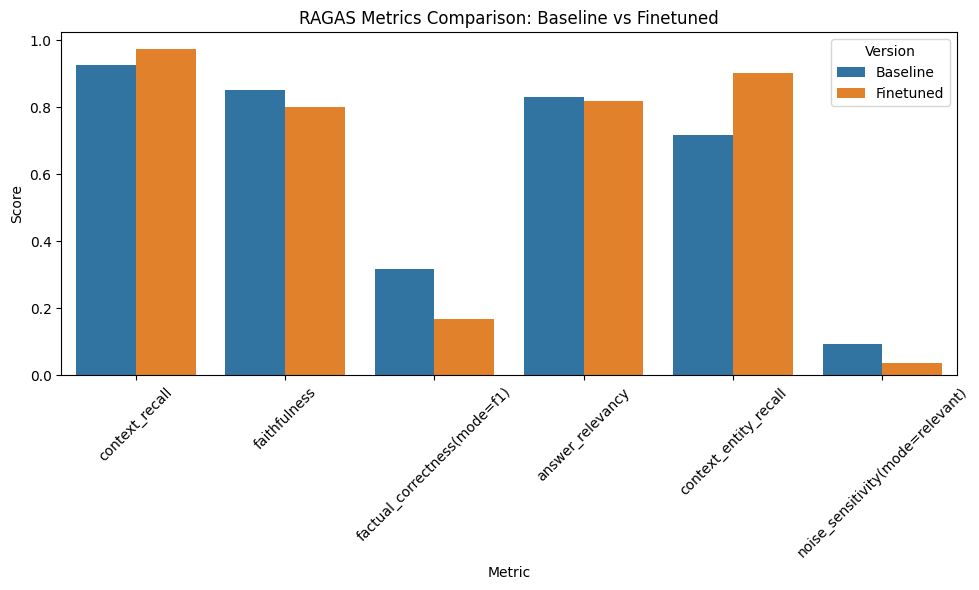

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

from config import settings

CACHE_DIR = Path(f"cache/{settings.DATASET_PREFIX}")
CACHE_DIR.mkdir(exist_ok=True)

def load_df(name: str):
    path = CACHE_DIR / f"{name}.csv"
    return pd.read_csv(path) if path.exists() else None

baseline_df = load_df("baseline_metrics")
finetuned_df = load_df("finetuned_metrics")

# Calculate the average of each metric
baseline_avg = baseline_df.mean(numeric_only=True)
finetuned_avg = finetuned_df.mean(numeric_only=True)

# Combine for visual comparison
comparison_df = pd.DataFrame({
    "Baseline": baseline_avg,
    "Finetuned": finetuned_avg
}).reset_index().rename(columns={"index": "Metric"})

# Plotting comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_df.melt(id_vars="Metric", var_name="Version", value_name="Score"), 
            x="Metric", y="Score", hue="Version")
plt.title("RAGAS Metrics Comparison: Baseline vs Finetuned")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **Task 7: Summary**

Here's a detailed summary report comparing **Baseline** and **Fine-tuned** RAG models:

---

## 📊 **RAGAS Evaluation Summary: Baseline vs. Fine-Tuned RAG**

| Metric                             | Baseline Score | Finetuned Score | % Change | Insights                                                                 |
|------------------------------------|----------------|-----------------|----------|--------------------------------------------------------------------------|
| context_recall                     | 0.93           | 0.975           | +4.84%   | Fine-tuned model retrieves more relevant context consistently.            |
| faithfulness                       | 0.85           | 0.80            | -5.88%   | Slight drop in staying close to source; may be due to abstraction.        |
| factual_correctness (mode=F1)     | 0.32           | 0.165           | -48.44%  | Major drop; factual hallucinations increased post-finetuning.             |
| answer_relevancy                   | 0.84           | 0.825           | -1.79%   | Minor decrease; fine-tuned answers are still topically aligned.           |
| context_entity_recall             | 0.72           | 0.90            | +25.00%  | Big gain; fine-tuned model is much better at identifying key entities.    |
| noise_sensitivity (mode=relevant) | 0.095          | 0.04            | -57.89%  | Strong improvement; less distracted by irrelevant content.                |


---

## 📌 **Insights: RAGAS Metrics Interpretation**

### 🔼 Improved Metrics

- **context_recall (+4.84%)**
  - The fine-tuned model retrieves more relevant passages with higher consistency.
  - This suggests improved alignment between embeddings and document content.

- **context_entity_recall (+25.00%)**
  - Fine-tuning helped the model focus better on key biblical entities (e.g., people, books, places).
  - This is valuable for question answering tasks grounded in specific theological references.

- **noise_sensitivity (mode=relevant) (-57.89%)**
  - A significant reduction in retrieving irrelevant or distracting content.
  - Indicates better semantic discrimination by the fine-tuned model.

---

### ⚖️ Stable Metric

- **answer_relevancy (-1.79%)**
  - Slight drop, but within tolerance. The answers remain mostly aligned with the user's question.
  - Suggests that despite changes in retrieval, coherence in responses is preserved.

---

### 🔽 Regressed Metrics

- **faithfulness (-5.88%)**
  - Minor decrease in how well answers adhere to source material.
  - May indicate increased abstraction or paraphrasing behavior in the generation phase.

- **factual_correctness (mode=F1) (-48.44%)**
  - Major decline in factual accuracy.
  - Signals the need for enhanced control mechanisms (e.g., factuality re-rankers or answer verification) during generation.

---

## 📈 **Recommended Next Steps**

1. **Improve Factual Correctness:**

   * Use RAGAS-generated hallucination examples to fine-tune the model on factual answering.
   * Add NLI (Natural Language Inference) or factual reranking stages post-generation.

2. **Boost Faithfulness:**

   * Modify prompt instructions to enforce answer grounding.
   * Add more "chain-of-thought + evidence alignment" examples during fine-tuning.

3. **RAG Optimization:**

   * Consider reranking retrieved chunks or increasing `k` for retrieval.
   * Use sentence-level retrieval or chunk-fusion if entity recall is crucial.

4. **Instrumentation:**

   * Integrate [RAGAS feedback loop](https://github.com/explodinggradients/ragas) for continuous evaluation & regression tracking.
